## Goals:
- try training more features
- reducing over fitting
- increase accuracy

In [1]:
import os
from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree

def move_data(filepath, src, dest): # Function for moving files - split training and testing data into files
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print(" " + food, end=" ")
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
        try:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
        except:
            return

In [2]:
# Create data txt files with cheesecake, ceasar salad, and chicken curry
def create_food_list(filepath, food_list_filepath, food_list):
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        
    food_list_file = open(food_list_filepath, "w")
    for p in paths:
        food = p.split('/')
        #print(food)
        if food[0] in food_list:
            food_list_file.write(p + "\n")
                #final_food_list.append(p)
    food_list_file.close()

In [4]:
food_list = ['lasagna', 'baklava', 'carrot_cake', 'ramen', 'churros', 'oysters', 'guacamole', 'grilled_salmon']

create_food_list('meta/train.txt', 'meta/train7_Draft3.txt', food_list)
create_food_list('meta/test.txt', 'meta/test7_Draft3.txt', food_list)

In [5]:
move_data('meta/train7_Draft3.txt', 'images', 'Data/train7_Draft3') 

 baklava  carrot_cake  churros  grilled_salmon  guacamole  lasagna  oysters  ramen 

In [6]:
move_data('meta/test7_Draft3.txt', 'images', 'Data/test7_Draft3') 

 baklava  carrot_cake  churros  grilled_salmon  guacamole  lasagna  oysters  ramen 

## Getting Image Data Ready

In [7]:
import tensorflow as tf

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [9]:
image_size = (235, 235)
batch_size = 16

train_gen = data_gen.flow_from_directory('Data/train7_Draft3', target_size=image_size, batch_size=batch_size) # class_mode default categorical
test_gen = data_gen.flow_from_directory('Data/test7_Draft3', target_size=image_size, batch_size=batch_size)

Found 6000 images belonging to 8 classes.
Found 2000 images belonging to 8 classes.


In [10]:
image_shape = (235, 235, 3)

## Load InceptionV3

In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False)  # include top freeze weights
inception_model.trainable=False   # don't retrain weights - transfer learn

## Model 1

In [26]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, GlobalAveragePooling2D

model1 = Sequential()
model1.add(inception_model)
model1.add(Dropout(0.2))

model1.add(Conv2D(32, 2, activation='relu'))  #filters=32, strides=2, kernel_size=(5,5),
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(32, 2, activation='relu'))
model1.add(GlobalAveragePooling2D()) # avg output of feature map
model1.add(Dense(8, activation='softmax'))

model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
dropout_14 (Dropout)         (None, 6, 6, 2048)        0         
_________________________________________________________________
conv2d_202 (Conv2D)          (None, 5, 5, 32)          262176    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_203 (Conv2D)          (None, 1, 1, 32)          4128      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)               

In [27]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopping = EarlyStopping(min_delta=0.001, patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='models/draft3/model1.h5', verbose=1, save_best_only=True, save_weights_only=True)

In [30]:
history1 = model1.fit(train_gen, validation_data=test_gen, epochs=30, verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/30
375/375 [==============================] - 137s 366ms/step - loss: 1.1794 - accuracy: 0.5927 - val_loss: 0.7256 - val_accuracy: 0.7950

Epoch 00001: val_loss improved from inf to 0.72556, saving model to models/draft3\model1.h5
Epoch 2/30
375/375 [==============================] - 142s 379ms/step - loss: 0.7808 - accuracy: 0.7547 - val_loss: 0.5864 - val_accuracy: 0.8200

Epoch 00002: val_loss improved from 0.72556 to 0.58640, saving model to models/draft3\model1.h5
Epoch 3/30
375/375 [==============================] - 146s 389ms/step - loss: 0.6497 - accuracy: 0.7982 - val_loss: 0.6592 - val_accuracy: 0.8030

Epoch 00003: val_loss did not improve from 0.58640
Epoch 4/30
375/375 [==============================] - 142s 378ms/step - loss: 0.5679 - accuracy: 0.8247 - val_loss: 0.5643 - val_accuracy: 0.8245

Epoch 00004: val_loss improved from 0.58640 to 0.56431, saving model to models/draft3\model1.h5
Epoch 5/30
375/375 [==============================] - 142s 379ms/step - loss:

In [31]:
# Save model
model1.save("models/draft3/model1.h5")

## Plot

<AxesSubplot:>

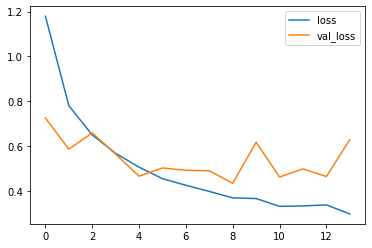

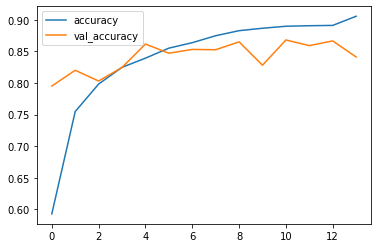

In [32]:
import pandas as pd

history_df = pd.DataFrame(history1.history)
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:,['accuracy', 'val_accuracy']].plot()

In [33]:
print(max(history_df['val_accuracy']))

0.8679999709129333


In [34]:
print(max(history_df['accuracy']))

0.9054999947547913


# Convert to tf lite - Flutter

In [35]:
import tensorflow as tf
assert tf.__version__.startswith('2')

In [36]:
pip install tensorflow==2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2
ERROR: No matching distribution found for tensorflow==2


In [37]:
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()
with open('models/draft3/model1.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ariel\AppData\Local\Temp\tmp33xc_6r6\assets


In [38]:
print(train_gen.class_indices)

{'baklava': 0, 'carrot_cake': 1, 'churros': 2, 'grilled_salmon': 3, 'guacamole': 4, 'lasagna': 5, 'oysters': 6, 'ramen': 7}


In [39]:
labels = '\n'.join(sorted(train_gen.class_indices.keys()))

In [42]:
with open('models/draft3/labels.txt', 'w') as f:
    f.write(labels)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(history1)
tflite_model = converter.convert()
with open('models/draft2/model1.tflite', 'wb') as f:
  f.write(tflite_model)